In [1]:


import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import tifffile
import skimage
import pyvips
from skimage import io, transform
from scipy import ndimage as nd
from mpl_toolkits.axes_grid1 import ImageGrid
import json

In [2]:


BASE_PATH = "./"
TRAIN_PATH = os.path.join(BASE_PATH, "train")



In [3]:
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "train.csv")
)
df_train

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
2,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
3,0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
4,e79de561c,7464094 14 7480273 41 7496453 67 7512632 82 75...
5,095bf7a1f,113430380 22 113468538 67 113506697 111 113544...
6,54f2eec69,124601765 36 124632133 109 124662536 147 12469...
7,1e2425f28,49453112 7 49479881 22 49506657 31 49533433 40...


In [4]:


df_sub = pd.read_csv(
    os.path.join(BASE_PATH, "sample_submission.csv"))
df_sub



,id,predicted
0,b9a3865fc,NaN
1,b2dc8411c,NaN
2,26dc41664,NaN
3,c68fe75ea,NaN
4,afa5e8098,NaN


In [5]:


df_info = pd.read_csv(
    os.path.join(BASE_PATH, "HuBMAP-20-dataset_information.csv")
)
df_info.sample(3)



,image_file,width_pixels,height_pixels,anatomical_structures_segmention_file,glomerulus_segmentation_file,patient_number,race,ethnicity,sex,age,weight_kilograms,height_centimeters,bmi_kg/m^2,laterality,percent_cortex,percent_medulla
1,54f2eec69.tiff,22240,30440,54f2eec69-anatomical-structure.json,54f2eec69.json,67548,Black or African American,Not Hispanic or Latino,Male,58,79.9,190.5,22.0,Right,75,25
6,26dc41664.tiff,42360,38160,26dc41664-anatomical-structure.json,26dc41664.json,68304,White,Not Hispanic or Latino,Female,66,71.3,167.6,25.4,Left,55,45
3,e79de561c.tiff,27020,16180,e79de561c-anatomical-structure.json,e79de561c.json,67026,Black or African American,Not Hispanic or Latino,Male,53,73.0,166.0,26.5,Left,55,45


# EDA

In [6]:
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T


def read_image(image_id, scale=None, verbose=1):
    image = tifffile.imread(
        os.path.join(BASE_PATH, f"train/{image_id}.tiff")
    )
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    mask = rle2mask(
        df_train[df_train["id"] == image_id]["encoding"].values[0], 
        (image.shape[1], image.shape[0])
    )
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
        print(f"[{image_id}] Mask shape: {mask.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        mask = cv2.resize(mask, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
            print(f"[{image_id}] Resized Mask shape: {mask.shape}")
        
    return image, mask


def read_test_image(image_id, scale=None, verbose=1):
    image = tifffile.imread(
        os.path.join(BASE_PATH, f"test/{image_id}.tiff")
    )
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
        
    return image


def plot_image_and_mask(image, mask, image_id):
    plt.figure(figsize=(16, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Image {image_id}", fontsize=18)
    
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(mask, cmap="hot", alpha=0.5)
    plt.title(f"Image {image_id} + mask", fontsize=18)    
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap="hot")
    plt.title(f"Mask", fontsize=18)    
    
    plt.show()
    
    
def plot_grid_image_with_mask(image, mask):
    plt.figure(figsize=(16, 16))
    n_cols = 4
    n_rows = 4
    col_start = 0
    col_w = 2500
    row_start = 0
    row_w = 2500
    for i in range(n_cols):
        for j in range(n_rows):
            plt.subplot(n_cols, n_rows, n_rows * i + j + 1)
            sub_image = image[
                col_start + i * col_w : col_start + (i + 1) * col_w, 
                row_start + j * row_w : row_start + (j + 1) * row_w, 
                :
            ]
            sub_mask = mask[
                col_start + i * col_w : col_start + (i + 1) * col_w, 
                row_start + j * row_w : row_start + (j + 1) * row_w, 
            ]
            plt.imshow(sub_image)
            plt.imshow(sub_mask, cmap="hot", alpha=0.5)
            plt.axis("off")
    plt.show()
    

def plot_slice_image_and_mask(image, mask, start_h, end_h, start_w, end_w):
    plt.figure(figsize=(16, 5))
    
    sub_image = image[start_h:end_h, start_w:end_w, :]
    sub_mask = mask[start_h:end_h, start_w:end_w]
    
    plt.subplot(1, 3, 1)
    plt.imshow(sub_image)
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(sub_image)
    plt.imshow(sub_mask, cmap="hot", alpha=0.5)
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(sub_mask, cmap="hot")
    plt.axis("off")
    
    plt.show()

In [7]:


small_ids = [
    "0486052bb"
]
small_images = []
small_masks = []

for small_id in small_ids:
    tmp_image, tmp_mask = read_image(small_id, scale=5, verbose=0)
    small_images.append(tmp_image)
    small_masks.append(tmp_mask)



KeyboardInterrupt: 

In [ ]:


plt.figure(figsize=(64, 64))
for ind, (tmp_id, tmp_image, tmp_mask) in enumerate(zip(small_ids, small_images, small_masks)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(tmp_image)
    plt.imshow(tmp_mask, cmap="hot", alpha=0.5)
    plt.axis("off")



In [ ]:
def getSingleFTU(mask):
    '''
    divides a mask for one pic into many masks each containing single FTU mask
    not used now
    '''
    labels, nlabels = nd.label(mask)
    label_masks = []
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        #label_masks.append(label_mask)
        yield label_mask
def getFTUs(image,mask):
    '''
    from an image and a mask, get list of images of FTUs
    '''
    ftus = []
    labels, nlabels = nd.label(mask)
    for label_ind, label_coords in enumerate(nd.find_objects(labels)):
        cell = image[label_coords]
        ftus.append(cell)
    return ftus

In [ ]:
#plot random selection of FTUs from an image
indices = np.random.randint(len(ftus), size=(10))
ftus_selection = np.array(ftus)[indices]

for i,image in zip(indices,ftus_selection):
    plt.figure()
    plt.imshow(image)
    plt.title('label = {}'.format(i), fontsize=8)

# DATALOADER

In [7]:
# needed to transform pyvips.Image to ndarray
format_to_dtype = {
    'uchar': np.uint8,
    'char': np.int8,
    'ushort': np.uint16,
    'short': np.int16,
    'uint': np.uint32,
    'int': np.int32,
    'float': np.float32,
    'double': np.float64,
    'complex': np.complex64,
    'dpcomplex': np.complex128,
}

In [8]:
def show_kidney(image, mask, alpha = 0.5):
    """Show image with mask"""
    plt.imshow(image)
    plt.imshow(mask, cmap="hot", alpha=alpha)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [57]:
# tutorial can be found here:
# https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html
# class to load one pic
class KidneyFTUsDataset(Dataset):
    '''
    Kdiney with FTU mask dataset
    '''
    def __init__(self, csv_file, root_dir, tile_size = 1024, transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with pic name and rle encoding.
            root_dir (string): Directory with all the images.
            tile_size (int): the size of cropped image (tile_size*tile_size)
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.tile_size = tile_size
        self.patient_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        self.image_list = []
        self.cropped_images = []
        self.mask_list = []
        self.cropped_masks = []
        self.read_image_list()
        self.crop_images()
    
    def __len__(self):
        return len(self.cropped_images)
    
    def __getitem__(self, idx):
            if torch.is_tensor(idx):
                idx = idx.tolist()
            cropped_image = self.cropped_images[idx]
            mask = self.cropped_masks[idx]
            
            image = np.ndarray(buffer = cropped_image.write_to_memory(),
                                dtype = format_to_dtype[cropped_image.format], 
                                shape = (cropped_image.height, cropped_image.width, 
                                cropped_image.bands))
            
            if image.shape != (self.tile_size,self.tile_size):
                imframe = np.zeros((self.tile_size,self.tile_size,image.shape[2]),
                                   dtype = image.dtype)
                imframe[:image.shape[0],:image.shape[1],:] = image
                image = imframe
                mkframe = np.zeros((self.tile_size,self.tile_size),
                                   dtype = image.dtype)
                mkframe[:mask.shape[0],:mask.shape[1]] = mask
                mask = mkframe
                
            sample = {'image': image, 'mask': mask}

            if self.transform:
                sample = self.transform(sample)
            
            return sample
    def read_image_list(self):
        for i in (self.patient_frame['id']):
            self.image_list.append(pyvips.Image.new_from_file(os.path.join(self.root_dir,
                                        i+'.tiff'), access='random'))
        return self.image_list
        
    def crop_images(self):
        for i,image in enumerate(self.image_list):
            number_x_tiles = int(np.floor(image.width/self.tile_size))
            number_y_tiles = int(np.floor(image.height/self.tile_size))
    
            left = np.array([j*self.tile_size for j in range(number_x_tiles)])
            top = np.array([j*self.tile_size for j in range(number_y_tiles)])
    
            crop_start_point = np.array(np.meshgrid(left,top))
            crop_start_point = crop_start_point.T.reshape(-1, 2)
    
            rle = df_train.iloc[i, 1]
            mask = rle2mask(rle,(image.width,image.height))
            self.mask_list.append(mask.T)
            for j,points in enumerate(crop_start_point):
                cropped = image.crop(points[0], points[1], self.tile_size, self.tile_size)
                cropped_mask = self.mask_list[i][points[0]:points[0]+self.tile_size, 
                                    points[1]:points[1]+self.tile_size]
                self.cropped_images.append(cropped)
                self.cropped_masks.append(cropped_mask.T)
                
            # treat borders like a queen
            # right-side border:
            for j in top:
                cropped = image.crop(
                    left[-1]+self.tile_size, 
                    j, 
                    image.width-left[-1]-self.tile_size, 
                    self.tile_size
                )
                cropped_mask = self.mask_list[i][left[-1]+self.tile_size:, 
                                    j:j+self.tile_size]
                self.cropped_images.append(cropped)
                self.cropped_masks.append(cropped_mask.T)
                
            # bottom border:
            for j in left:
                cropped = image.crop(
                    j, 
                    top[-1]+self.tile_size, 
                    self.tile_size,
                    image.height-top[-1]-self.tile_size
                )
                cropped_mask = self.mask_list[i][j:j+self.tile_size, 
                                            top[-1]+self.tile_size:]
                self.cropped_images.append(cropped)
                self.cropped_masks.append(cropped_mask.T)
                
            # corner
            cropped = image.crop(left[-1]+self.tile_size,
                                 top[-1]+self.tile_size,
                                image.width-left[-1]-self.tile_size,
                                image.height-top[-1]-self.tile_size)
            cropped_mask = self.mask_list[i][left[-1]+self.tile_size:, 
                                        top[-1]+self.tile_size:]
            self.cropped_images.append(cropped)
            self.cropped_masks.append(cropped_mask.T)



## check that custom dataset class actually does something

In [59]:
ftu_dataset = KidneyFTUsDataset(csv_file=os.path.join(BASE_PATH, "train.csv"),
                                    root_dir=TRAIN_PATH)

In [22]:
sample = ftu_dataset[4900]

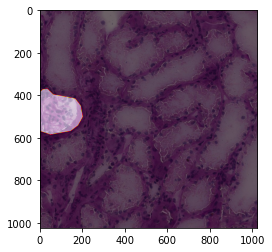

In [23]:
show_kidney(**sample)

## Transformations

In [27]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        print(image.shape)
        print((new_h, new_w,3))
        img = transform.resize(image, (new_h, new_w,3))
        mask = transform.resize(mask, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        #mask = mask * [new_w / w, new_h / h]

        return {'image': img, 'mask': mask}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'mask': mask}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask)}

## check transforms are actually doing something

transformation #0 is done!


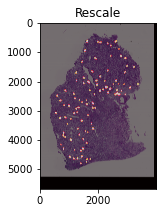

transformation #1 is done!


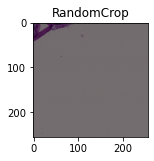

transformation #2 is done!


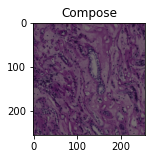

In [13]:
scale = Rescale(4000)
crop = RandomCrop(256)
composed = transforms.Compose([Rescale(4096),
                               RandomCrop(256)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = ftu_dataset[1]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    print ('transformation #{} is done!'.format(i))

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_kidney(**transformed_sample)

plt.show()

In [28]:
transformed_dataset = KidneyFTUsDataset(csv_file=os.path.join(BASE_PATH, "train.csv"),
                                        root_dir=TRAIN_PATH,
                                        transform=transforms.Compose([
                                            ToTensor()
                                           ]))


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fd4e158d6a0>>
Traceback (most recent call last):
  File "/home/alcauchy/anaconda3/envs/kaggle/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/alcauchy/anaconda3/envs/kaggle/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/alcauchy/anaconda3/envs/kaggle/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/home/alcauchy/anaconda3/envs/kaggle/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/alcauchy/anaconda3/envs/kaggle/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [ ]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['mask'].size())

    if i == 3:
        break

In [61]:
dataloader = DataLoader(ftu_dataset, batch_size=4,
                        shuffle=True, num_workers=1)

0 torch.Size([4, 1024, 1024, 3]) torch.Size([4, 1024, 1024])
1 torch.Size([4, 1024, 1024, 3]) torch.Size([4, 1024, 1024])
2 torch.Size([4, 1024, 1024, 3]) torch.Size([4, 1024, 1024])
3 torch.Size([4, 1024, 1024, 3]) torch.Size([4, 1024, 1024])


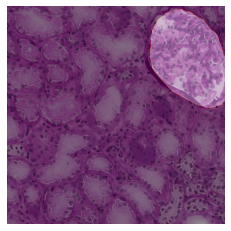

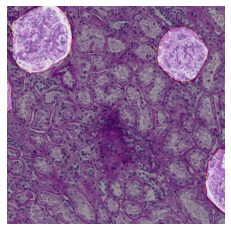

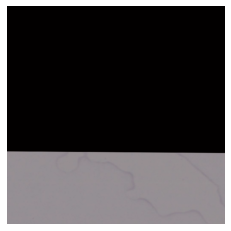

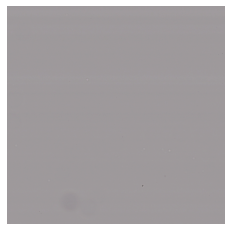

In [62]:
# Helper function to show a batch
def show_mask_batch(sample_batched):
    """Show image with masks for a batch of samples."""
    images_batch, masks_batch = \
            sample_batched['image'], sample_batched['mask']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    #plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    grid1 = utils.make_grid(masks_batch)
    plt.imshow(grid1.numpy().T)

    #for i in range(batch_size):
     #   plt.scatter(masks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
      #              masks_batch[i, :, 1].numpy() + grid_border_size,
       #             s=10, marker='.', c='r')

    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['mask'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        
        plt.figure()
        for i,im in enumerate(sample_batched['image']):
            plt.axis('off')
            plt.ioff()
            plt.imshow(im)
            plt.imshow(sample_batched['mask'][i],cmap = 'hot', alpha = 0.3)
            plt.show()
        break